In [1]:
import sys
sys.path.append("/g/data/zk16/zelun/z_li_hon/wonglab_github/borzoi/examples")

In [2]:
import json
import os
import time
import warnings

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

from borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2024-02-02 13:07:39.921494: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-02 13:07:42.168930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 13:08:02.453512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
%%bash

cd "/g/data/zk16/zelun/z_li_hon/wonglab_github/borzoi/examples"

In [5]:
%%bash

#Download model weights
# for fold in f0 f1 f2 f3; do
#   mkdir -p "saved_models/$fold/"
#   local_model="saved_models/$fold/model0_best.h5"
#   if [ -f "$local_model" ]; then
#     echo "$fold model already exists."
#   else
#     wget --progress=bar:force "https://storage.googleapis.com/seqnn-share/borzoi/$fold/model0_best.h5" -O "$local_model"
#   fi
# done

#Download and uncompress annotation files
if [ -f gencode41_basic_nort.gtf ]; then
  echo "Annotation already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > gencode41_basic_nort.gtf
fi
if [ -f gencode41_basic_protein_splice.csv.gz ]; then
  echo "Splice sites already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz
fi
if [ -f polyadb_human_v3.csv.gz ]; then
  echo "PolyA sites already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz
fi

#Download and index hg38 genome
if [ -f hg38.fa ]; then
  echo "Human genome FASTA already exists."
else
  wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38.fa
fi

--2023-12-15 14:24:12--  https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.24.59, 2404:6800:4006:804::201b
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.24.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30909907 (29M) [application/octet-stream]
Saving to: ‘STDOUT’

     0K .......... .......... .......... .......... ..........  0%  369K 82s
    50K .......... .......... .......... .......... ..........  0%  365K 82s
   100K .......... .......... .......... .......... ..........  0% 20.4M 55s
   150K .......... .......... .......... .......... ..........  0% 24.8M 42s
   200K .......... .......... .......... .......... ..........  0% 17.6M 33s
   250K .......... .......... .......... .......... ..........  0% 26.0M 28s
   300K .......... .......... .......... .......... ..........  1% 1.26M 27s
   350K .......... .......... .......... ...

Process is interrupted.


In [5]:
os.chdir('/g/data/zk16/zelun/z_li_hon/wonglab_github/borzoi/examples')

In [6]:
pyfaidx.Faidx('hg38.fa')

Faidx("hg38.fa")

In [7]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_folds = 1       #To use only one model fold, set to 'n_folds = 1'. To use all four folds, set 'n_folds = 4'.
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets
# NOTE: Target file is used later for indexing purpose 
targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create a local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    # Note: Remove the pair that is not in the strand pair
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for fold_ix in range(n_folds) :
    
    model_file = "saved_models/f" + str(fold_ix) + "/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    # NOTE: update '0' to [0]
    seqnn_model.build_ensemble(rc, [0])
    
    models.append(seqnn_model)


2024-02-02 13:08:37.052820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31085 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b1:00.0, compute capability: 7.0


In [8]:
slice_pair

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88], dtype=int32)

In [9]:
#Initialize fasta sequence extractor

fasta_open = pysam.Fastafile('hg38.fa')

#Load splice site annotation 
# NOTE: why do we need splice site annotation?

splice_df = pd.read_csv('gencode41_basic_protein_splice.csv.gz', sep='\t', compression='gzip')

print("len(splice_df) = " + str(len(splice_df)))


len(splice_df) = 404837


In [10]:
#Load GTF (optional; needed to compute exon coverage attributions for example gene)

# NOTE: This is needed to compute exon coverage attributions
transcriptome = bgene.Transcriptome('gencode41_basic_nort.gtf')

# NOTE: The emsemble ID of the gene KIAA1598 : Chromosome 10: 118,643,742-118,886,097 reverse strand.
search_gene = 'ENSG00000187164'
# NOTE: given the centre position it will extend to the full seq_len 524288
center_pos = 116952944
chrom = 'chr10'
# NOTE: these are the positions to change the nucleotide
poses = [116952944]
# NOTE: The Nucleotides to change to
alts = ['C']


start = center_pos - seq_len // 2
end = center_pos + seq_len // 2


#Get exon bin range
# NOTE: Getting the exon coordinates for a particular gene using Emsemble ID
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

# NOTE: The name of the first gene
gene = transcriptome.genes[gene_keys[0]]
print(f"this is the first {gene}")

#Determine output sequence start
# NOTE: calculating the start and end coordinate of the output seq
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]


#Determine output positions of gene exons
# NOTE: Each of is a 32bp slice
"""
# clip left boundaries
exon_seq_start = max(0, exon.begin - seq_start)
exon_seq_end = max(0, exon.end - seq_start)

# requires >50% overlap
slice_start = int(np.round(exon_seq_start / model_stride))
slice_end = int(np.round(exon_seq_end / model_stride))

# clip right boundaries
slice_max = int(seq_len / model_stride)
slice_start = min(slice_start, slice_max)
slice_end = min(slice_end, slice_max)

gene_slice.extend(range(slice_start, slice_end))
"""
# NOTE: Finding the slice number that contains the gene
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False)
print(f"this is gene slice {gene_slice}")


print(f"seq_out_start {seq_out_start}")
print(f"seq_out_len {seq_out_len}")
print(f"seqnn_model_strides {seqnn_model.model_strides}")
print(f"seqnn_model_strides {seqnn_model.model_strides[0]}")

this is the first <baskerville.gene.Gene object at 0x14f5ab47c850>
this is gene slice [ 5943  5944  5945  5946  5947  5948  5949  5950  5951  5952  5953  5954
  5955  5956  5957  5958  5959  5960  5961  5962  5963  5964  5965  5966
  5967  5968  5969  5970  5971  5972  5973  5974  5975  5976  5977  5978
  5979  5980  5981  5982  5983  5984  5985  5986  5987  5988  5989  5990
  5991  5992  5993  5994  5995  5996  5997  5998  5999  6000  6001  6002
  6003  6004  6005  6006  6007  6008  6009  6010  6011  6012  6013  6014
  6015  6016  6017  6018  6019  6020  6021  6022  6023  6024  6025  6026
  6027  6028  6029  6030  6031  6032  6033  6034  6035  6036  6037  6038
  6039  6040  6041  6042  6043  6044  6045  6046  6047  6048  6049  6050
  6051  6052  6053  6054  6055  6056  6057  6058  6059  6060  6061  6062
  6063  6064  6065  6066  6067  6068  6069  6070  6071  6072  6073  6074
  6075  6076  6077  6078  6079  6080  6081  6082  6083  6084  6085  6086
  6087  6088  6089  6090  6091  6092  

In [11]:
#Print index of GTEx blood and muscle tracks in targets file

targets_df['local_index'] = np.arange(len(targets_df))

print("blood tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:blood']['local_index'].tolist()))
print("muscle tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:muscle']['local_index'].tolist()))


blood tracks = [9, 10, 11]
muscle tracks = [47, 48, 49]


2024-02-02 13:09:12.976410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


-- Counts --
 - sum_wt = 134628.16
 - sum_mut = 136860.84
 - max_y_wt = 1051.197
 - max_y_mut = 1060.9895
 -- (max_y = 1060.9895)


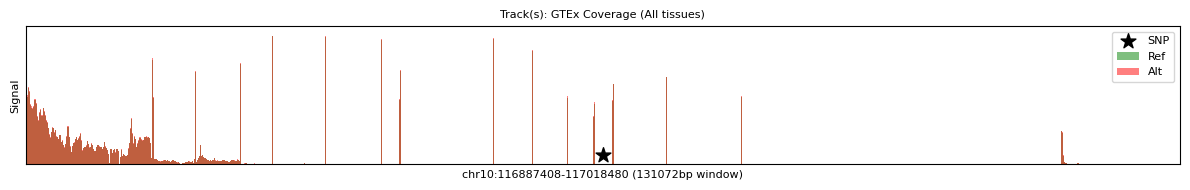

 - sum_wt = 75068.61
 - sum_mut = 90392.24
 - max_y_wt = 696.2884
 - max_y_mut = 837.6076
 -- (max_y = 837.6076)


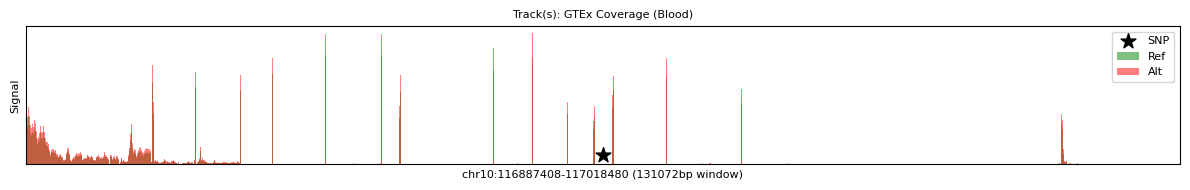

 - sum_wt = 44652.867
 - sum_mut = 45602.734
 - max_y_wt = 425.3462
 - max_y_mut = 430.3084
 -- (max_y = 430.3084)


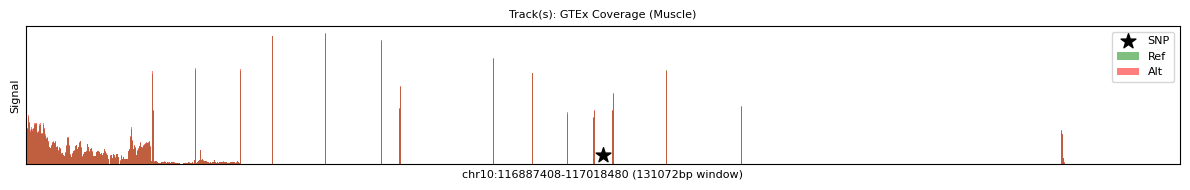

CPU times: user 37.4 s, sys: 1.19 s, total: 38.6 s
Wall time: 41.9 s


In [12]:
%%time
#Predict for chr10_116952944_T_C
# (~6 minutes on CPU w 1 fold; ~2 minutes on GPU)
  
#NOTE: In this case, it is doing an SNP swap here

save_figs = False
save_suffix = '_chr10_116952944_T_C'

# NOTE: Getting the output sequence given chromosome number, start index and end index
sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

# NOTE: What is this trying to alternate
for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

#Visualize quantized tracks over SNP

plot_window = 131072
bin_size = 32
pad = 16

rescale_tracks = True
normalize_counts = False

anno_df = None #splice_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [9, 10, 11],
    [47, 48, 49],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Blood)',
    'GTEx Coverage (Muscle)',
]

track_scales = [0.01]*3
track_transforms = [3./4.]*3
soft_clips = [384.]*3

print("-- Counts --")
plot_coverage_track_pair_bins(
    y_wt,
    y_mut,
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=1 * plot_window,
    bin_size=bin_size,
    pad=pad,
    rescale_tracks=rescale_tracks,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    anno_df=anno_df,
)


In [13]:
def seq_replace_with_one_hot(wt_seq, replacement_seq, middle_index, start_index, end_index, seq_len=524288):
    """
    This function replaces a one hot sequence (wt_seq) with another one hot sequence (replacement_seq).

    
    Args: 
    1. wt_seq (np.array): The original sequence that needs to be replaced.
    2. replacement_seq (str): The new sequence that will replace the original sequence.
    3. middle_index (int): The midpoint of the genome coordinate of the input sequence
    4. start_index (int): The starting genome index of the replacement sequence
    5. end_index (int): The ending genome index of the replacement sequence

    
    Returns:
    The updated one hot sequence after replacement.
    """
    sequence_replaced = np.copy(wt_seq)
    
    replace_start_index = (seq_len // 2) + (start_index - middle_index)
    replace_end_index = (seq_len // 2) + (end_index - middle_index)
    
    sequence_replaced[replace_start_index:replace_end_index] =  dna.dna_1hot(replacement_seq).astype("float32")

    return sequence_replaced

    

-- Counts --
 - sum_wt = 134628.16
 - sum_mut = 136465.73
 - max_y_wt = 1051.197
 - max_y_mut = 1044.0533
 -- (max_y = 1051.197)


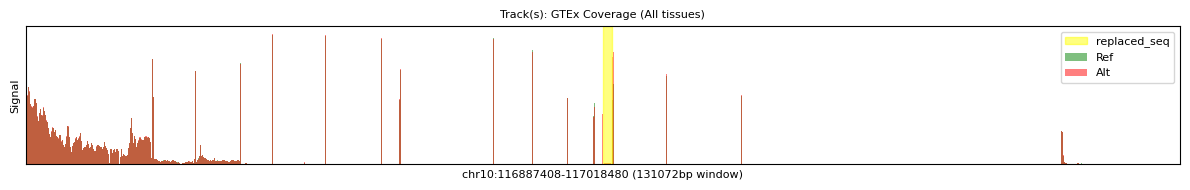

 - sum_wt = 75068.61
 - sum_mut = 70242.95
 - max_y_wt = 696.2884
 - max_y_mut = 1265.1941
 -- (max_y = 1265.1941)


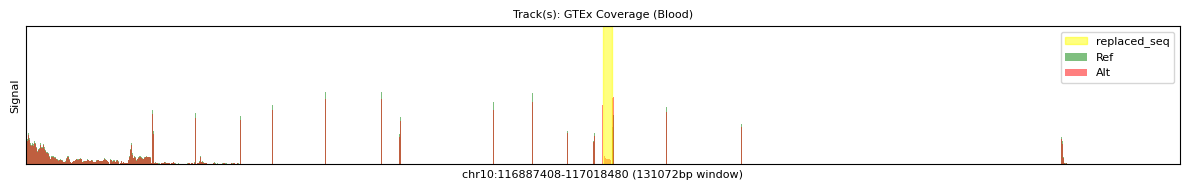

 - sum_wt = 44652.867
 - sum_mut = 46342.082
 - max_y_wt = 425.3462
 - max_y_mut = 684.3701
 -- (max_y = 684.3701)


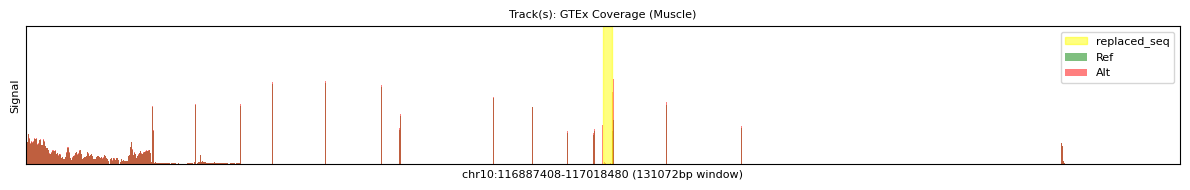

CPU times: user 31.1 s, sys: 380 ms, total: 31.4 s
Wall time: 32.9 s


In [14]:
%%time
##############################################
# ZELUN version of long sequence replacement #
##############################################

#Predict for chr10_116952944_T_C
# (~6 minutes on CPU w 1 fold; ~2 minutes on GPU)
  
#NOTE: In this case, it is doing an SNP swap here

save_figs = False
save_suffix = '_chr10_116952944_LONG_CONVERSION'

# NOTE: Getting the output sequence given chromosome number, start index and end index
sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)

# NOTE: REPLACEMENT Coordinate
# The centre position is at 116952944
# Can make sure this can do long replacement
# Could code up the flexibility with a set length sequence to be replaced at the middle
# I am Not sure about the particular user case so I haven't coded up anything specific, like replacing in the centre of the input sequence of a user set fixed length 
# But in the new notebook I've demonstrated that you could replace longer sequence into it
replacement_start = 116952944
replacement_end = 116953944
replacement_seq = 'A'*1000
sequence_one_hot_mut = seq_replace_with_one_hot(sequence_one_hot_wt, replacement_seq, center_pos, replacement_start, replacement_end)

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

#Visualize quantized tracks over SNP

plot_window = 131072
bin_size = 32
pad = 16

rescale_tracks = True
normalize_counts = False

anno_df = None #splice_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [9, 10, 11],
    [47, 48, 49],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Blood)',
    'GTEx Coverage (Muscle)',
]

track_scales = [0.01]*3
track_transforms = [3./4.]*3
soft_clips = [384.]*3

print("-- Counts --")
plot_coverage_track_pair_bins(
    y_wt,
    y_mut,
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=1 * plot_window,
    bin_size=bin_size,
    pad=pad,
    rescale_tracks=rescale_tracks,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    anno_df=anno_df,
    long_seq_replacement=True,
    seq_replace_start=replacement_start,
    seq_replace_end=replacement_end
)





In [18]:
%%time
#Get contribution scores (gradient) for blood GTEX tracks
# (~20 minutes on CPU; otherwise runnable only on 40GB GPU cards, e.g. A100)

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=target_index[[9, 10, 11]].tolist(),
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=False,
    use_ratio=False,
    use_logodds=False,
    subtract_avg=True,
    fold_index=np.arange(n_folds).tolist(),
)


1/1 [==============================] - 14s 14s/step
CPU times: user 15min 52s, sys: 10.8 s, total: 16min 3s
Wall time: 6min 45s


--- WT ---


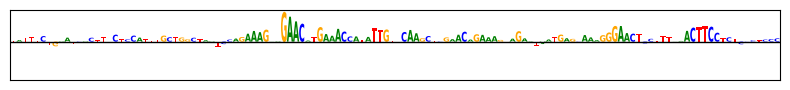

--- Mut ---


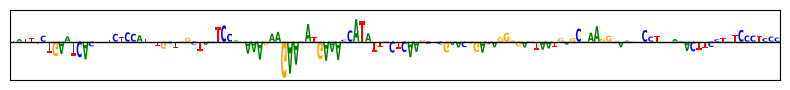

In [19]:
#Visualize gradient contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


In [24]:
%%time
#Get contribution scores (ISM) for blood GTEX tracks
# (not feasible to run on CPU; ~33 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    ism_start=(poses[0] - start) - 64,
    ism_end=(poses[0] - start) + 64,
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=[9, 10, 11],
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0
example_ix = 1
CPU times: user 9min 16s, sys: 39.9 s, total: 9min 55s
Wall time: 19min 39s


--- WT ---


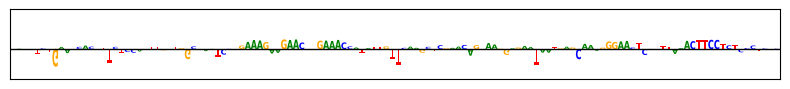

--- Mut ---


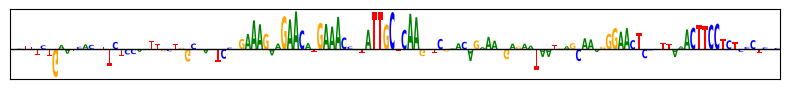

In [12]:
#Visualize ISM contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


In [13]:
%%time
#Get contribution scores (ISM shuffle) for blood GTEX tracks
# (not feasible to run on CPU; ~135 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    ism_start=(poses[0] - start) - 64,
    ism_end=(poses[0] - start) + 64,
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=[9, 10, 11],
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    window_size=5,
    n_samples=12,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0
example_ix = 1
CPU times: user 1h 6min 55s, sys: 6min 8s, total: 1h 13min 3s
Wall time: 2h 15min 9s


--- WT ---


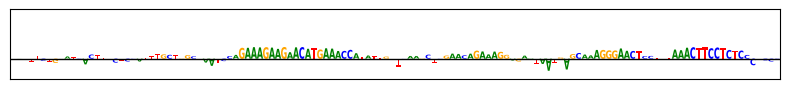

--- Mut ---


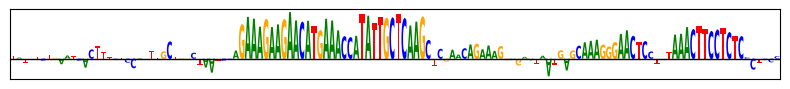

In [14]:
#Visualize ISM Shuffle contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_snp_4_folds_gtex_blood_cov_undo_clip'
)


In [15]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()


gtex_targets_wt.shape = (16352, 32)
gtex_targets_mut.shape = (16352, 32)
-- Counts --
 - sum_wt = 27668.607
 - sum_mut = 37653.69
 - max_y_wt = 241.0508
 - max_y_mut = 370.9016
 -- (max_y = 370.9016)


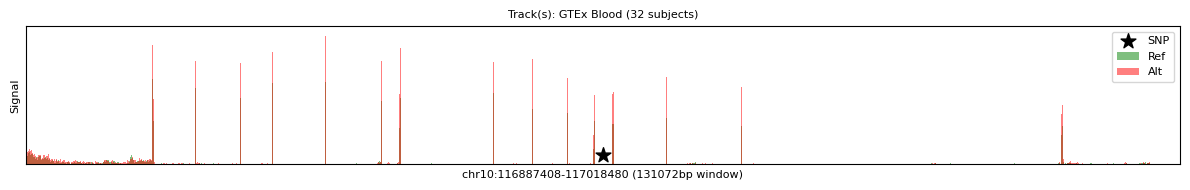

In [16]:
#Visualize measured coverage tracks for chr10_116952944_T_C

save_figs = False
save_suffix = '_chr10_116952944_T_C_meas_32_subjects'

center_pos = 116952944

chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "/home/drk/common/data/genomes/hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 16, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 16, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

plot_window = 131072
bin_size = 32
pad = 16

anno_df = None #splice_df

rescale_tracks = True
normalize_counts = True

#Tracks
track_indices = [
    np.arange(32).tolist(),
]

track_names = [
    'GTEx Blood (32 subjects)',
]

track_scales = [
    0.01,
]

track_transforms = [
    3./4.,
]

soft_clips = [
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(
    gtex_targets_wt[None, None, ...],
    gtex_targets_mut[None, None, ...],
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=4 * plot_window,
    bin_size=bin_size,
    pad=pad,
    rescale_tracks=rescale_tracks,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    anno_df=anno_df,
)
